In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F
import math


In [6]:
import torch
print("PyTorch version:", torch.__version__)
print("HIP version:", torch.version.hip)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))

PyTorch version: 2.9.1+rocm7.1.1.git351ff442
HIP version: 7.1.52802-26aae437f6
CUDA available: True
Device name: AMD Radeon RX 9070 XT


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## **Data Collection and Loading**

We load the 64×64 RGB cat face images from disk, resize them if needed, and store them in a NumPy array.  
Basic info (count, shape, value range) is displayed to confirm that the dataset is properly loaded.

In [ ]:
import os
import subprocess

DATA_DIR = "../data/cats_dataset"
ZIP_PATH = "../data/cats-faces-64x64-for-generative-models.zip"  

def download_cats_dataset():
    os.makedirs("../data", exist_ok=True)

    # Si le dataset est déjà extrait
    if os.path.exists(DATA_DIR):
        print("Dataset already exists.")
        return

    # Si le zip n'existe pas, on le télécharge
    if not os.path.exists(ZIP_PATH):
        print("Downloading dataset from Kaggle...")
        cmd = [
            "kaggle", "datasets", "download",
            "-d", "spandan2/cats-faces-64x64-for-generative-models",
            "-p", "../data",
            "--force"
        ]
        subprocess.run(cmd, check=True)
        print("Download done.")

    # Extraction
    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall("../data")

    print("Dataset successfully downloaded and extracted.")

download_cats_dataset()
print(f"Dataset directory: {DATA_DIR}")

Dataset directory: ../data/cats_dataset


In [9]:
def load_cat_images(data_dir, max_images=None):
    """
    Load cat face images from directory
    Returns: numpy array of shape (n_samples, 64, 64, 3)
    """
    image_files = list(Path(data_dir).glob('*.jpg')) + list(Path(data_dir).glob('*.png'))
    
    if max_images:
        image_files = image_files[:max_images]
    
    images = []
    for img_path in image_files:
        img = Image.open(img_path).convert('RGB')
        img = img.resize((64, 64))  # Ensure 64x64
        images.append(np.array(img))
    
    return np.array(images)


In [10]:
data_dir="../data/cats"
# Load images
images = load_cat_images(data_dir)
print(f"Loaded {len(images)} images")
print(f"Image shape: {images[1].shape}")
print(f"Data type: {images.dtype}")
print(f"Value range: [{images.min()}, {images.max()}]")

Loaded 15747 images
Image shape: (64, 64, 3)
Data type: uint8
Value range: [0, 255]


## **Data Visualization**

Below we display a few sample images from the dataset to verify that the data has been loaded correctly and to get a quick sense of the visual content we will train the model on.


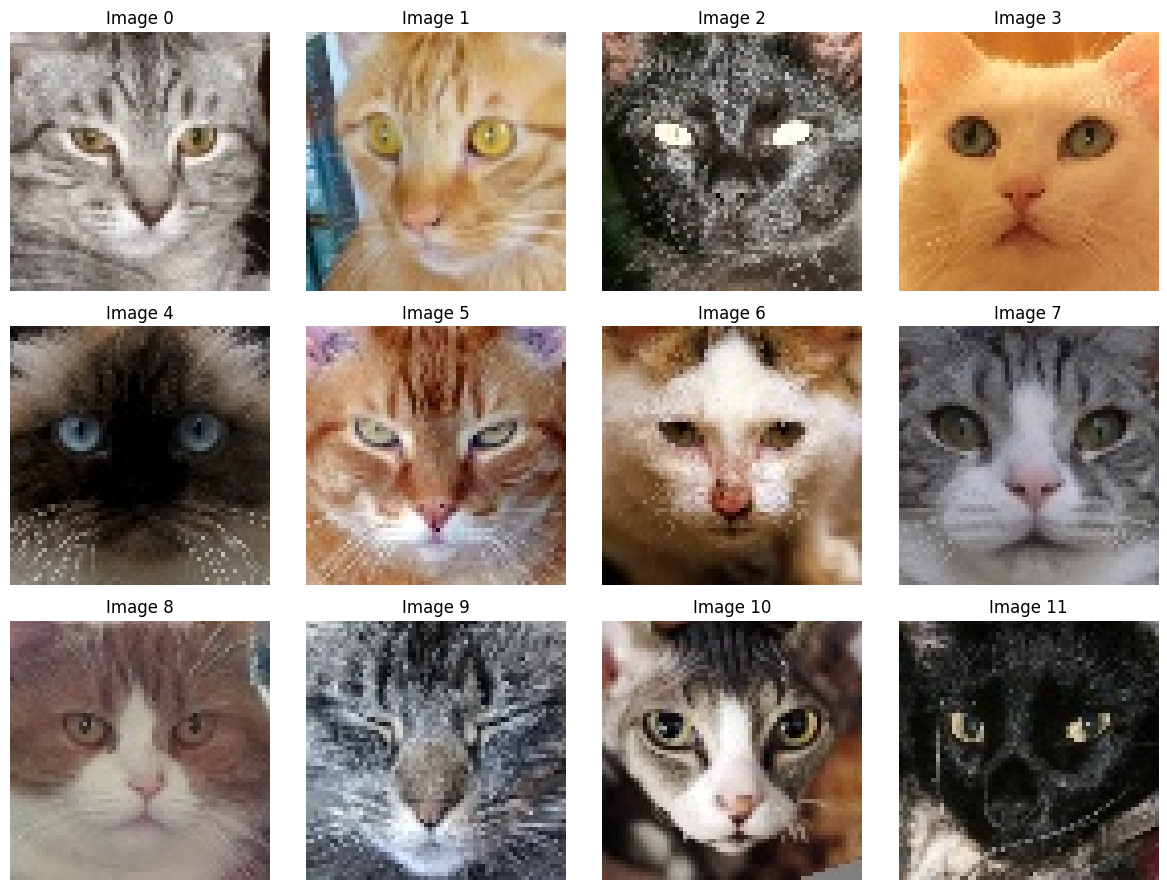

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

for i in range(12):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title(f'Image {i}')

plt.tight_layout()
plt.show()

# **Data Preparation**

Before training the diffusion model, we prepare the dataset so that it matches the expected input format of the U-Net and the diffusion process. This preprocessing step ensures that all images share the same scale, numerical range, and tensor layout.


### **1. Normalization to $[-1, 1]$**

Diffusion models work best when inputs lie in a symmetric range, typically $[-1, 1]$.  
Each image (initially in $[0, 255]$) is rescaled using:

$$
x = \frac{x - 127.5}{127.5}
$$

This transformation centers the data around zero and improves numerical stability in both the forward and reverse diffusion steps.


### **2. Reordering tensor dimensions**

Images loaded from disk usually follow the layout:

$$
(H,\, W,\, C)
$$

PyTorch convolution layers expect the format:

$$
(C,\, H,\, W)
$$

We therefore transpose the axes accordingly.


### **3. Train/Validation split**

To monitor model generalization, the dataset is divided into:

- **90%** for training,  
- **10%** for validation.

The validation loss provides an early indicator of overfitting.


### **4. Conversion to tensors and dataloaders**

After normalization and reshaping, the images are converted to PyTorch tensors and wrapped into:

- a `TensorDataset`,  
- a `DataLoader` with appropriate batching and shuffling.

This enables efficient mini-batch sampling during training.


In [12]:
#Preprocessing for diffusion model

images_normalized = (images.astype('float32') - 127.5) / 127.5

images_normalized = images_normalized.transpose(0,3,1,2)
print(f"Normalized shape: {images_normalized.shape}")
print(f"Normalized range: [{images_normalized.min():.3f}, {images_normalized.max():.3f}]")

# Split into train/validation sets
split_idx = int(0.9 * len(images_normalized))
train_images = images_normalized[:split_idx]
val_images = images_normalized[split_idx:]

print(f"\nTraining samples: {len(train_images)}")
print(f"Validation samples: {len(val_images)}")



train_images_tensor=torch.tensor(train_images).to(torch.float32)
val_images_tensor=torch.tensor(val_images).to(torch.float32)

train_dataset=TensorDataset(train_images_tensor)
val_dataset=TensorDataset(val_images_tensor)

batch_size=64

train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

Normalized shape: (15747, 3, 64, 64)
Normalized range: [-1.000, 1.000]

Training samples: 14172
Validation samples: 1575


## **Noise schedule and forward coefficients**

Now that the data are ready, we need to define **how the diffusion process adds noise** to an image.

In a DDPM, we fix a number of diffusion steps $T$. At each step $t \in \{0, \dots, T-1\}$ we add Gaussian noise with a variance controlled by a coefficient $ \beta_t $. In practice:

- $T = 300$  
- $ \beta_t $ increases linearly from $10^{-4}$ to $0.02$

In code, this sequence is stored in the tensor `betas` of length `T`.

From these $ \beta_t $ values we define

$$
\alpha_t = 1 - \beta_t
$$

and the cumulative product

$$
\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s .
$$

The term $ \bar{\alpha}_t $ tells us **how much of the original image $x_0$ is still present after $t$ diffusion steps**.  
We also precompute

$$
\sqrt{\bar{\alpha}_t}
\quad\text{and}\quad
\sqrt{1 - \bar{\alpha}_t},
$$

because they appear directly in the closed-form formula of the forward process:

$$
x_t = \sqrt{\bar{\alpha}_t}\, x_0 + \sqrt{1 - \bar{\alpha}_t}\, \varepsilon,
\qquad \varepsilon \sim \mathcal{N}(0, I).
$$

The function `q_sample(x0, t, noise=None)` below is a small helper that implements exactly this equation:

- it takes a batch of clean images `x0` and a batch of timesteps `t`,
- it samples a Gaussian noise `ε` (unless a specific noise tensor is provided),
- it returns the corresponding noisy images `x_t`.

The `print` at the end of the cell is just a quick sanity check to confirm that the tensors have the right shapes and that the first values of  
`sqrt_alpha_bars` and `sqrt_one_minus_alpha_bars` look reasonable.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [14]:
T = 300  # nombre d'étapes de diffusion

betas  = torch.linspace(1e-4, 0.02, T, dtype=torch.float32)   # (T,) CPU
alphas = 1.0 - betas                                          # (T,) CPU
alpha_bars = torch.cumprod(alphas, dim=0)                     # (T,) CPU

sqrt_alpha_bars           = torch.sqrt(alpha_bars)
sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - alpha_bars)

print("Shapes:", betas.shape, alphas.shape, alpha_bars.shape)
print("sqrt_alpha_bars[:5]:",        sqrt_alpha_bars[:5])
print("sqrt_1_minus_alpha_bars[:5]:", sqrt_one_minus_alpha_bars[:5])
print("sqrt_alpha_bars[:5] numpy:",   sqrt_alpha_bars[:5].numpy())



Shapes: torch.Size([300]) torch.Size([300]) torch.Size([300])
sqrt_alpha_bars[:5]: tensor([0.9999, 0.9999, 0.9998, 0.9996, 0.9994])
sqrt_1_minus_alpha_bars[:5]: tensor([0.0100, 0.0163, 0.0224, 0.0283, 0.0341])
sqrt_alpha_bars[:5] numpy: [0.99995    0.9998667  0.9997502  0.99960035 0.9994173 ]


In [15]:
def q_sample(x0, t, noise=None):
    """
    x0 : (B, C, H, W) sur device (cuda ou cpu)
    t  : (B,) sur device
    """
    if noise is None:
        noise = torch.randn_like(x0)

    # On indexe alpha_bars sur CPU, puis on envoie sur le device de x0
    a_bar_t = alpha_bars[t.cpu()]                 # (B,) CPU
    a_bar_t = a_bar_t.to(x0.device).view(-1,1,1,1)  # (B,1,1,1) sur device

    x_t = torch.sqrt(a_bar_t) * x0 + torch.sqrt(1.0 - a_bar_t) * noise
    return x_t, noise

### **Sanity Check and Forward Diffusion Visualisation**

Before training the diffusion model, it is useful to verify that the forward diffusion process is correctly implemented and behaves as expected.

In this cell, we perform two checks:

1. **Sanity check on random tensors**  
   We apply the function `q_sample(x0, t)` to random noise with random timesteps and inspect:
   - the shapes of the outputs,
   - the values of the selected timesteps,
   - the corresponding $ \bar{\alpha}_t $ values.  
   This confirms that the implementation is consistent at the tensor level.

2. **Visualisation on real images**  
   We take a small batch of real images from the training set and generate their noisy versions for several fixed timesteps:
   - $ t = 0 $ (clean images),
   - $ t = 50 $ (light noise),
   - $ t = 150 $ (moderate noise),
   - $ t = 299 $ (almost pure Gaussian noise).  

The goal is to visually confirm that the images are gradually destroyed as $ t $ increases, which is a key property of the forward diffusion process.

x_t_test shape: torch.Size([8, 3, 64, 64])
noise_test shape: torch.Size([8, 3, 64, 64])
t_test: tensor([ 31,   2,  81, 187, 189, 286, 265,  46], device='cuda:0')
alpha_bar[t_test]: tensor([0.9644, 0.9995, 0.7948, 0.3031, 0.2955, 0.0622, 0.0919, 0.9261])


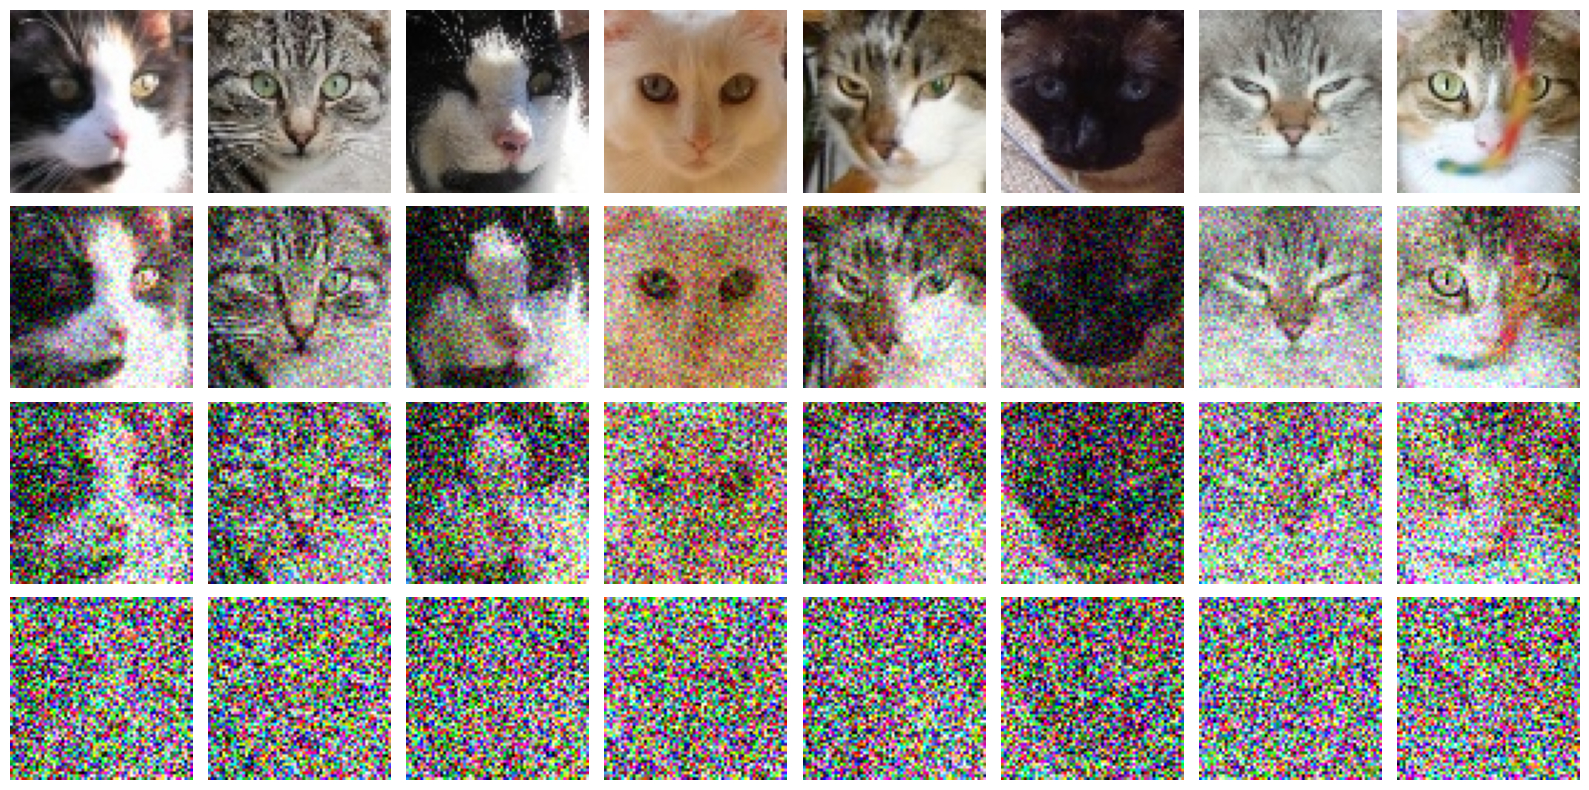

In [16]:
# Sanity check sur q_sample et visualisation du forward diffusion

# 1) Sanity check rapide sur des tenseurs aléatoires
x0_test = torch.randn(8, 3, 64, 64, device=device)
t_test  = torch.randint(0, T, (8,), device=device)

x_t_test, noise_test = q_sample(x0_test, t_test)

print("x_t_test shape:",   x_t_test.shape)
print("noise_test shape:", noise_test.shape)
print("t_test:",           t_test)
print("alpha_bar[t_test]:", alpha_bars[t_test.cpu()])  # on indexe sur CPU

# 2) Visualisation sur de vraies images du dataset
batch = next(iter(train_loader))
x0 = batch[0][:8].to(device)   # 8 premières images du batch

t_values = [0, 50, 150, 299]
noise = torch.randn_like(x0)   # même bruit epsilon pour toutes les valeurs de t

xs = [x0]  # t = 0 (images propres)
for t_scalar in t_values[1:]:
    t_tensor = torch.full(
        (x0.size(0),),
        t_scalar,
        dtype=torch.long,
        device=device,
    )
    x_t, _ = q_sample(x0, t_tensor, noise=noise)
    xs.append(x_t)

def to_numpy_img_batch(x):
    # [-1, 1] -> [0, 1]
    x = (x + 1) / 2
    x = torch.clamp(x, 0, 1)
    # (B, 3, 64, 64) -> (B, 64, 64, 3)
    return x.permute(0, 2, 3, 1).cpu().numpy()

num_rows = len(xs)        # 4 (t = 0, 50, 150, 299)
num_cols = x0.size(0)     # 8 images

fig, axes = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 * num_rows))
row_titles = [f"t = {t}" for t in t_values]

for row in range(num_rows):
    imgs = to_numpy_img_batch(xs[row])
    for col in range(num_cols):
        ax = axes[row, col]
        ax.imshow(imgs[col])
        ax.axis("off")
        if col == 0:
            ax.set_ylabel(row_titles[row], fontsize=10)

plt.tight_layout()
plt.show()

### **Interpretation of the Visualisation**

The grid of images shows the effect of the forward diffusion process on the same batch of cat images:

- At $ t = 0 $, the images are clean and correspond to the original dataset.
- At $ t = 50 $, a noticeable but moderate amount of Gaussian noise has been added; the cats are still clearly recognisable.
- At $ t = 150 $, most fine details have been destroyed and only a faint structure of the original images remains.
- At $ t = 299 $, the images are almost indistinguishable from pure Gaussian noise.

This behaviour is exactly what is expected from a correctly implemented diffusion process:

- Early timesteps keep most of the signal.
- Late timesteps converge towards the prior distribution $ \mathcal{N}(0, I) $.

Once this forward behaviour is validated, we can move on to the next step:  
training a neural network $ \varepsilon_\theta(x_t, t) $ to **predict the noise** added at each timestep, which will later allow us to reverse the diffusion process and generate new images.

## **Building the noise prediction model**

Up to this point, we have defined the forward diffusion process and verified that
images are progressively corrupted when the timestep increases.  
The next step is to build the neural network used during training:

$$
\varepsilon_\theta(x_t, t)
$$

This network receives:
- a noisy image $x_t$,
- the timestep $t$ indicating how much noise was added,

and learns to predict the noise that generated $x_t$.  
This is the core mechanism that allows us to reverse the diffusion process during sampling.

Before constructing the full U-Net, we first need a way to convert the timestep $t$ into
a continuous vector representation that the model can use.
This is the purpose of the **sinusoidal time embedding**, inspired by positional encodings in Transformers.

### **Sinusoidal Time Embedding**

The timestep $t$ is an integer in $\{0, \ldots, T-1\}$ that indicates how noisy the input image is.
However, a neural network cannot work effectively with raw integer values.
We therefore transform $t$ into a continuous embedding vector using sinusoidal functions.

This embedding has two important properties:

1. **It provides the model with a smooth notion of "where we are" in the diffusion trajectory.**  
   Small changes in $t$ produce small changes in the embedding, which helps the model
   interpolate between timesteps.

2. **It encodes information at multiple frequencies.**  
   Low frequencies capture global position, while high frequencies capture fine variations.
   This makes the encoding expressive even for large values of $t$.

Given an embedding dimension `dim`, we create `dim/2` frequencies
and compute:

$$
\text{emb}(t) = 
\big[ \sin(t \cdot f_1), \ldots, \sin(t \cdot f_{d/2}),
       \cos(t \cdot f_1), \ldots, \cos(t \cdot f_{d/2}) \big].
$$

The resulting vector has shape `(B, dim)` and will be injected into every block of the U-Net
to condition the denoising process on the timestep.

In [17]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        """
        t : (B,) timestamps (int ou float)
        return : (B, dim)
        """
        device = t.device
        half_dim = self.dim // 2

        # fréquences
        freqs = torch.exp(
            -torch.linspace(0, math.log(10000), half_dim, device=device)
        )

        # (B, half_dim)
        # Si t est int64, on le cast en float
        t = t.float()
        args = t[:, None] * freqs[None, :]

        # concat sin et cos → (B, dim)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return emb

## **Building the U-Net Architecture**

With the sinusoidal timestep embedding in place, we can now construct the neural network used to predict the noise added during the forward diffusion process.

The objective of the model is to take:
- a noisy image $x_t$,
- the corresponding timestep $t$,

and produce an estimate of the injected noise $\epsilon_\theta(x_t, t)$.  
This estimate will later allow us to reverse the diffusion trajectory and reconstruct an image step by step.

A U-Net architecture is particularly suited for this task. It processes the input at multiple spatial resolutions and uses skip connections to preserve fine details while capturing global structure. Each block is conditioned on the timestep through the temporal embedding, ensuring that the model adapts its behaviour to the noise level corresponding to $t$.

The following sections introduce:
1. the residual block used throughout the architecture,
2. the downsampling and upsampling modules,
3. the complete U-Net responsible for predicting $\epsilon_\theta(x_t, t)$.

In [18]:
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, time_dim):
        super().__init__()

        # Première convolution
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.gn1   = nn.GroupNorm(num_groups=8, num_channels=out_c)

        # Deuxième convolution
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.gn2   = nn.GroupNorm(num_groups=8, num_channels=out_c)

        # Projette l'embedding temporel dans out_c dimensions
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim, out_c)
        )

        # Shortcut (résidu)
        self.shortcut = (
            nn.Conv2d(in_c, out_c, kernel_size=1)
            if in_c != out_c else
            nn.Identity()
        )

    def forward(self, x, t_emb):
        """
        x    : (B, in_c, H, W)
        t_emb: (B, time_dim)
        """

        # Conv 1
        h = self.conv1(x)
        h = self.gn1(h)
        h = F.silu(h)

        # Injection du temps
        t_out = self.time_mlp(t_emb)       # (B, out_c)
        t_out = t_out[:, :, None, None]    # reshape → (B, out_c, 1, 1)
        h = h + t_out                      # broadcast sur H,W

        # Conv 2
        h = self.conv2(h)
        h = self.gn2(h)
        h = F.silu(h)

        # Résidu
        return h + self.shortcut(x)

In [19]:
class DownBlock(nn.Module):
    def __init__(self, in_c, out_c, time_dim):
        super().__init__()
        self.res = ResBlock(in_c, out_c, time_dim)
        self.down = nn.Conv2d(out_c, out_c, kernel_size=4, stride=2, padding=1)

    def forward(self, x, t_emb):
        h = self.res(x, t_emb)       # (B, out_c, H, W)
        x_down = self.down(h)        # (B, out_c, H/2, W/2)
        return x_down, h             # on renvoie aussi le skip


class UpBlock(nn.Module):
    def __init__(self, in_c, skip_c, out_c, time_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1)
        # après upsample : out_c canaux, qu’on concatène avec skip_c → out_c + skip_c
        self.res = ResBlock(out_c + skip_c, out_c, time_dim)

    def forward(self, x, skip, t_emb):
        x = self.up(x)                     # (B, out_c, 2H, 2W)
        x = torch.cat([x, skip], dim=1)    # (B, out_c + skip_c, 2H, 2W)
        x = self.res(x, t_emb)             # (B, out_c, 2H, 2W)
        return x

In [20]:
class SimpleUNet(nn.Module):
    def __init__(self, time_dim=128):
        super().__init__()
        self.time_dim = time_dim

        # Embedding temporel global
        self.time_embed = nn.Sequential(
            SinusoidalTimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )

        # Down : 64x64 -> 32x32 -> 16x16 -> 8x8
        self.down1 = DownBlock(3,   64,  time_dim)   # 64x64 -> 32x32
        self.down2 = DownBlock(64,  128, time_dim)   # 32x32 -> 16x16
        self.down3 = DownBlock(128, 256, time_dim)   # 16x16 -> 8x8

        # Bottleneck à 8x8
        self.bottleneck = ResBlock(256, 256, time_dim)
        # Up : 8x8 -> 16x16 -> 32x32 -> 64x64
        self.up3 = UpBlock(256, 256, 128, time_dim)   # 8x8 -> 16x16
        self.up2 = UpBlock(128, 128, 128, time_dim)   # 16x16 -> 32x32
        self.up1 = UpBlock(128,  64,  64,  time_dim)  # 32x32 -> 64x64

        # Projection finale vers 3 canaux (bruit prédit)
        self.out_conv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x, t):
        """
        x : (B, 3, 64, 64)  = x_t bruitées
        t : (B,)            = timestamps
        retourne : epsilon_theta(x_t, t) même shape que x
        """
        # Embedding temporel : (B, time_dim)
        t_emb = self.time_embed(t)

        # Encoder
        x1, h1 = self.down1(x, t_emb)   # x1: (B, 64, 32, 32), h1: (B, 64, 64, 64)
        x2, h2 = self.down2(x1, t_emb)  # x2: (B,128,16,16),  h2: (B,128,32,32)
        x3, h3 = self.down3(x2, t_emb)  # x3: (B,256, 8, 8),  h3: (B,256,16,16)

        # Bottleneck
        b = self.bottleneck(x3, t_emb)  # (B,256, 8, 8)

        # Decoder
        x = self.up3(b,  h3, t_emb)     # (B,128,16,16)
        x = self.up2(x,  h2, t_emb)     # (B,128,32,32)
        x = self.up1(x,  h1, t_emb)     # (B, 64,64,64)

        # Sortie
        out = self.out_conv(x)          # (B, 3, 64, 64)
        return out

## **Training the Noise Prediction Model**

With the U-Net architecture defined, we now move to the training phase.  
During the forward diffusion process, each image $x_0$ is progressively corrupted into a noisy version $x_t$ according to the closed-form relation:

$$
x_t = \sqrt{\bar{\alpha}_t}\, x_0 + \sqrt{1 - \bar{\alpha}_t}\, \epsilon,
\qquad \epsilon \sim \mathcal{N}(0, I).
$$

The objective of the network is to learn the function  
$\epsilon_\theta(x_t, t)$ that predicts the noise $\epsilon$ used to generate $x_t$.

This leads to the standard DDPM training loss:

$$
\mathcal{L}(\theta)
= \mathbb{E}_{x_0,\, t,\, \epsilon}
\left[
\left\| \epsilon - \epsilon_\theta(x_t, t) \right\|_2^2
\right].
$$

The training loop therefore follows a simple structure:

1. Sample a batch of clean images $x_0$.  
2. Sample random timesteps $t$.  
3. Generate noisy versions $x_t$ using the forward diffusion formula.  
4. Ask the model to predict the noise.  
5. Minimise the MSE between the true and predicted noise values.

The next cells implement:
- the loss function `get_loss`,  
- the training loop `train_model`,  
- logging of training and validation loss.

Together, these components allow the model to learn the noise structure necessary for the reverse diffusion process.

In [21]:
def get_loss(model,x0,t):
    noise=torch.randn_like(x0)
    x_t,_=q_sample(x0, t,noise=noise)
    eps_pred=model(x_t,t)
    loss=F.mse_loss(eps_pred,noise)
    return loss

In [22]:
def train_model(model, train_loader, val_loader, device, epochs=20, lr=2e-4):
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    history={'train_loss':[],'val_loss':[]}

    for epoch in range(epochs):
        model.train()
        train_loss_epoch = 0.0
        num_batches_train = 0
        for batch in train_loader:
            x0=batch[0]
            x0=x0.to(device)
            B=x0.size(0)
            t=torch.randint(0,T,(B,),device=device)
            loss=get_loss(model,x0,t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_epoch+=loss.item()
            num_batches_train+=1
        train_loss_epoch /= num_batches_train

        model.eval()
        val_loss_epoch=0.0
        num_batches_val=0
        with torch.no_grad():
            for batch in val_loader:
                x0=batch[0]
                x0=x0.to(device)
                B=x0.size(0)
                t=torch.randint(0,T,(B,),device=device)
                loss=get_loss(model,x0,t)
                val_loss_epoch+=loss.item()
                num_batches_val+=1
        val_loss_epoch /= num_batches_val
        
        history['train_loss'].append(train_loss_epoch)
        history['val_loss'].append(val_loss_epoch)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"train_loss = {train_loss_epoch:.4f} | "
              f"val_loss = {val_loss_epoch:.4f}")
    return history

In [23]:
def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(6,4))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
print(device)

Epoch 1/120 | train_loss = 0.1373 | val_loss = 0.0798
Epoch 2/120 | train_loss = 0.0748 | val_loss = 0.0709
Epoch 3/120 | train_loss = 0.0681 | val_loss = 0.0645
Epoch 4/120 | train_loss = 0.0644 | val_loss = 0.0623
Epoch 5/120 | train_loss = 0.0610 | val_loss = 0.0617
Epoch 6/120 | train_loss = 0.0600 | val_loss = 0.0627
Epoch 7/120 | train_loss = 0.0577 | val_loss = 0.0589
Epoch 8/120 | train_loss = 0.0577 | val_loss = 0.0595
Epoch 9/120 | train_loss = 0.0566 | val_loss = 0.0571
Epoch 10/120 | train_loss = 0.0567 | val_loss = 0.0561
Epoch 11/120 | train_loss = 0.0548 | val_loss = 0.0546
Epoch 12/120 | train_loss = 0.0539 | val_loss = 0.0580
Epoch 13/120 | train_loss = 0.0554 | val_loss = 0.0531
Epoch 14/120 | train_loss = 0.0541 | val_loss = 0.0565
Epoch 15/120 | train_loss = 0.0545 | val_loss = 0.0546
Epoch 16/120 | train_loss = 0.0544 | val_loss = 0.0552
Epoch 17/120 | train_loss = 0.0531 | val_loss = 0.0553
Epoch 18/120 | train_loss = 0.0533 | val_loss = 0.0556
Epoch 19/120 | trai

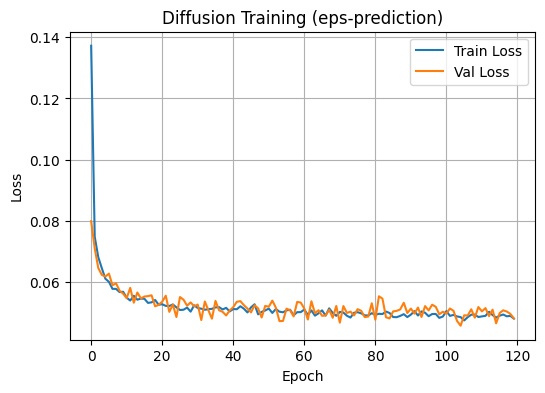

In [24]:
model = SimpleUNet().to(device)
history = train_model(model, train_loader, val_loader, device, epochs=120, lr=2e-4)
plot_training_history(history, title="Diffusion Training (eps-prediction)")

## **Reverse Diffusion: Computing $x_{t-1}$ from $x_t$**

Once the noise prediction model is trained, we can invert the diffusion process.  
Starting from a Gaussian sample $x_T \sim \mathcal{N}(0, I)$, the goal is to progressively denoise it until reaching $x_0$.

At each timestep $t$, the model predicts the noise component $\epsilon_\theta(x_t, t)$.  
From this prediction, we compute the mean of the reverse transition:

$$
\mu_\theta(x_t, t)
= \frac{1}{\sqrt{\alpha_t}}
\left(
x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \, \epsilon_\theta(x_t, t)
\right),
$$

which corresponds to the expected value of $x_{t-1}$.  
If $t > 0$, we add a small stochastic term:

$$
x_{t-1} = \mu_\theta(x_t, t) + \sigma_t z, \qquad z \sim \mathcal{N}(0, I),
$$

where $\sigma_t$ is derived from the diffusion schedule.

The function below implements this single reverse step $x_t \rightarrow x_{t-1}$.

In [25]:
@torch.no_grad()
def p_sample_step(model, x_t, t_scalar):
    """
    Un pas de reverse diffusion : x_t -> x_{t-1}

    x_t      : (B, 3, 64, 64)
    t_scalar : entier Python, 0 <= t_scalar < T
    """

    B = x_t.size(0)
    t_batch =torch.full((B,), t_scalar,device=x_t.device,dtype=torch.long)

    eps_theta = model(x_t,t_batch)

    alpha_t = alphas[t_scalar]
    alpha_bar_t = alpha_bars[t_scalar]
    beta_t = betas[t_scalar]

    sqrt_one_over_alpha = torch.sqrt(1.0 / alpha_t)
    sqrt_one_minus_alpha_bar = torch.sqrt(1.0 - alpha_bar_t)

    mu = sqrt_one_over_alpha * (
        x_t - (beta_t / sqrt_one_minus_alpha_bar) * eps_theta
    )

    if t_scalar > 0:
        alpha_bar_prev = alpha_bars[t_scalar - 1]
        tilde_beta_t = (1.0 - alpha_bar_prev) / (1.0 - alpha_bar_t) * beta_t
        sigma = torch.sqrt(tilde_beta_t)
        z = torch.randn_like(x_t)
        x_prev = mu + sigma * z
    else:
        x_prev = mu

    return x_prev

## **Generating New Images via Reverse Diffusion**

We now have all the components required to generate images from pure noise.  
The sampling procedure follows the DDPM reverse process:

1. Draw an initial noisy input  
   $$x_T \sim \mathcal{N}(0, I).$$

2. For timesteps $t = T-1, \dots, 0$, compute $x_{t-1}$ using the reverse diffusion step.

3. Convert the final tensor from the range $[-1, 1]$ to $[0, 1]$ so that it can be displayed as an image.

This iterative refinement process gradually transforms random noise into a structured image sampled from the learned data distribution.  
The next cell implements this full sampling pipeline.

In [26]:
@torch.no_grad()
def sample(model, n_samples, device):
    """
    Génère n_samples images en partant de x_T ~ N(0, I)
    et en appliquant le reverse diffusion jusqu'à t = 0.

    Retourne un tenseur x_0 de shape (n_samples, 3, 64, 64)
    dans l'intervalle [0, 1], prêt pour l'affichage.
    """
    model.eval()

    # 1) Bruit initial x_T ~ N(0, I)
    x_t = torch.randn(n_samples, 3, 64, 64, device=device)

    # 2) Reverse diffusion : t = T-1, ..., 0
    for t_scalar in reversed(range(T)):
        x_t = p_sample_step(model, x_t, t_scalar)

    # 3) x_0 dans [-1, 1] -> [0, 1] pour affichage
    x_0 = (x_t + 1) / 2
    x_0 = torch.clamp(x_0, 0, 1)

    return x_0

## **Visualising the Generated Samples**

The images below illustrate the output of the sampling process.  
Each one begins as a random Gaussian tensor at timestep $T$ and is progressively refined during the reverse diffusion.

Visual inspection of these samples provides an intuitive measure of:
- the coherence of the learned distribution,
- the model's denoising ability,
- the overall quality of the generative process.

This step is essential for assessing whether the diffusion model has learned meaningful structure rather than memorising noise.

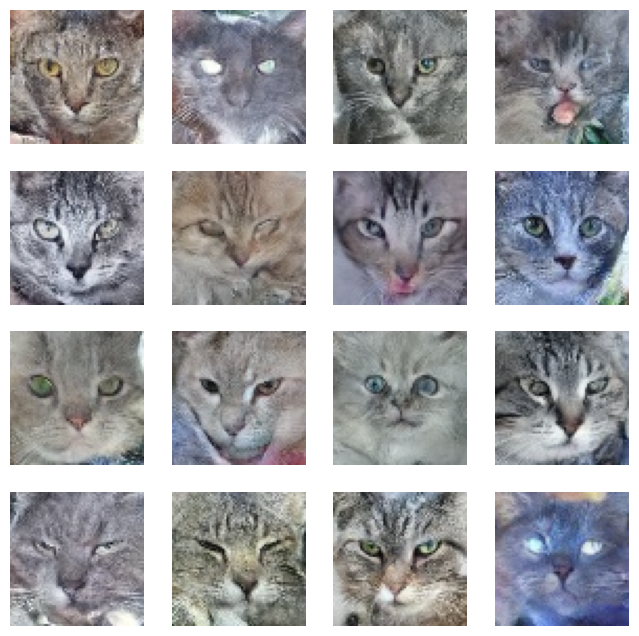

In [31]:
samples = sample(model, n_samples=16, device=device)

# Affichage simple
grid = samples.permute(0,2,3,1).cpu().numpy()
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(grid[i])
    plt.axis("off")
plt.show()

# **Saving the Trained DDPM**

After training, we save the model's weights so that the generator can be reused later for sampling, comparison with other generative models, or for inference in a separate notebook.  
Only the `state_dict` is saved, following PyTorch best practices.

In [30]:
save_path = "../models/diffusion_generator_cats.pth"

torch.save(model.state_dict(), save_path)
print(f"Generator successfully saved to: {save_path}")

Generator successfully saved to: ../models/diffusion_generator_cats.pth
